In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import daft
import seaborn 
import matplotlib.pyplot as plt



C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


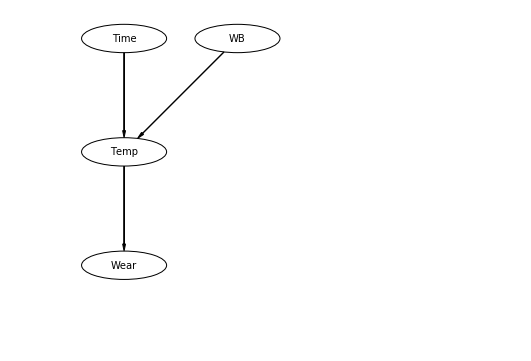

In [2]:
pgm = daft.PGM([9,6],origin=[1, 0.5])
pgm.add_node(daft.Node('Tme','Time',3,6,aspect=3))
pgm.add_node(daft.Node('WB','WB',5,6,aspect=3))
pgm.add_node(daft.Node('Temp','Temp',3,4,aspect=3))
pgm.add_node(daft.Node('Wear','Wear',3,2,aspect=3))
pgm.add_edge('Tme','Temp')
pgm.add_edge('WB','Temp')
pgm.add_edge('Temp','Wear')
pgm.render();


In [3]:
df = pd.read_csv('C:/Users/DESUSAI/Desktop/New folder/Temp.csv',sep=';')
Maxlife = 100000
intialTime=20

In [4]:
df.describe()

,Time,Temp,RunningTemp,Wear,Slot
count,5.0,5.000000,5.000000,5.000000,5.000000
mean,1.0,140.000000,172.800000,15.200000,3.000000
std,0.0,54.772256,15.205262,3.114482,1.581139
min,1.0,100.000000,166.000000,12.000000,1.000000
25%,1.0,100.000000,166.000000,13.000000,2.000000
50%,1.0,100.000000,166.000000,15.000000,3.000000
75%,1.0,200.000000,166.000000,16.000000,4.000000
max,1.0,200.000000,200.000000,20.000000,5.000000


In [5]:
temp_mean= df.Temp.mean()
temp_mean

140.0

In [6]:
df.skew()

Time           0.000000
Temp           0.608581
RunningTemp    2.236068
Wear           0.933451
Slot           0.000000
dtype: float64

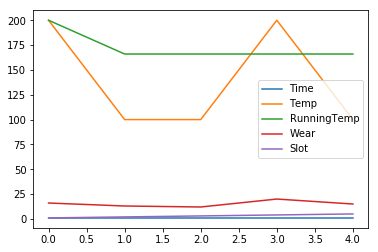

In [7]:
df.plot()
plt.show()

In [8]:
model = pm.Model();
with model:
    time = pm.Normal('time',intialTime)
    temp = pm.Normal('temp',mu=time)
    wear =pm.Normal('wear',mu=temp)
    trace = pm.sample(100000,tune=50000,progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████████████████████████████| 150000/150000 [03:24<00:00, 732.80it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EE447B8>,
      dtype=object)

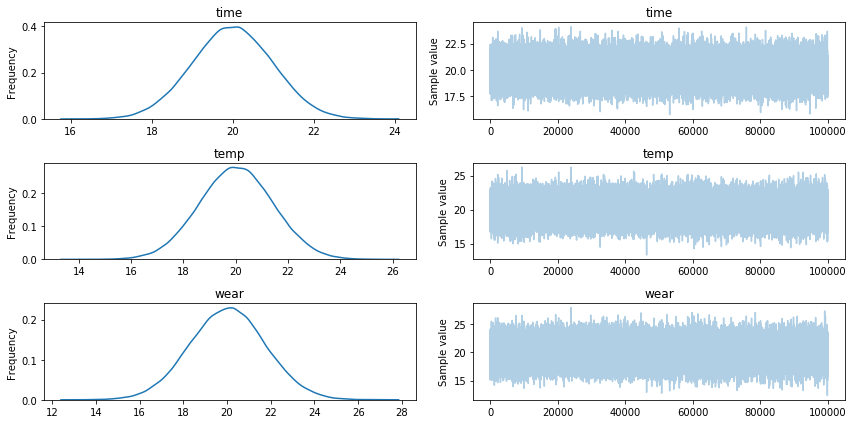

In [9]:
pm.traceplot(trace)

In [10]:
pm.summary(trace)


time:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.994           0.994            0.005            [18.041, 21.930]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  18.048         19.324         19.993         20.665         21.939


temp:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.993           1.411            0.007            [17.305, 22.822]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  17.236         19.043         19.990         20.943         22.756


wear:

  Mean             SD               MC Error         95% HPD interval
  ----------------------

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EFBE1D0>,
      dtype=object)

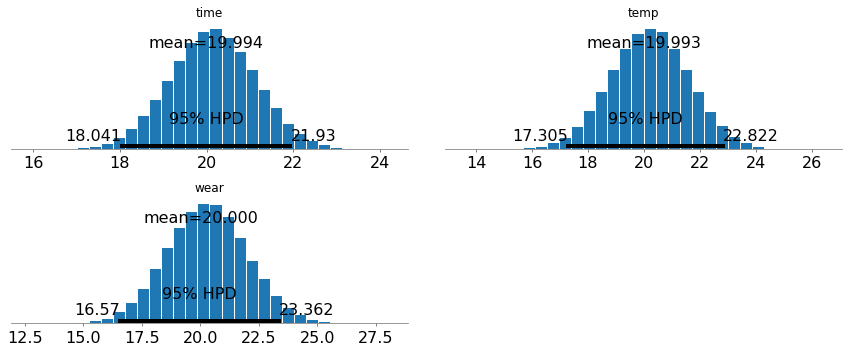

In [11]:
pm.plot_posterior(trace)

In [12]:
pred = pd.DataFrame({
    "Wear": trace["wear"][50000:],
    "Temp": trace["temp"][50000:],
    "Time": trace["time"][50000],
 
})


In [13]:
pred.Wear.mean()


19.992425271399686

In [14]:
pred.Temp.mean()
loopTime = pred.Time.mean()
loopWear = pred.Wear.mean()
loopTemp = pred.Temp.mean()

In [15]:
loopWear

19.992425271399686

In [16]:
loopTemp

19.986618585721647

In [17]:
loopTime

21.286463581731258

In [18]:
for i in range(0,len(df.Time)-1):    
    model2 = pm.Model();    
    with model2:        
        Time2 = pm.Normal('Time2',df.Time[i])
        Temp2 = pm.Normal('Temp2',mu=Time2+loopWear)
        wear2 = pm.Normal('wear2',mu=Temp2+loopWear)
        changedWear= pm.Normal('changedWear',mu=wear2-loopWear)
        trace2 = pm.sample(10000,tune=5000,progressbar=True)    
        globals()["predStep" + str(i)]= pd.DataFrame({
                    "Wear": trace2["wear2"][5000:],
                    "temp": trace2["Temp2"][5000:],
                    "time": trace2["Time2"][5000:],
                    "WearChanged": trace2["changedWear"][5000:]            
        })        
        globals()["predStep" + str(i)].to_csv('C:/Users/DESUSAI/Desktop/New folder/predStep_' + str(i+1)+'.csv', sep=';')
               
        loopTime = globals()["predStep" + str(i)].time.mean()
        loopWear = globals()["predStep" + str(i)].Wear.mean()        
        print(df.Time[i],' sec',round(((Maxlife-loopWear)/Maxlife)*100),'% life is left')        
        
        
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|███████████████████████████████████| 15000/15000 [00:23<00:00, 648.57it/s]


1  sec 100 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|███████████████████████████████████| 15000/15000 [00:25<00:00, 597.99it/s]


1  sec 100 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████| 15000/15000 [00:27<00:00, 554.09it/s]


1  sec 100 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████| 15000/15000 [00:23<00:00, 645.73it/s]


1  sec 100 % life is left


In [19]:
type(predStep0)

pandas.core.frame.DataFrame

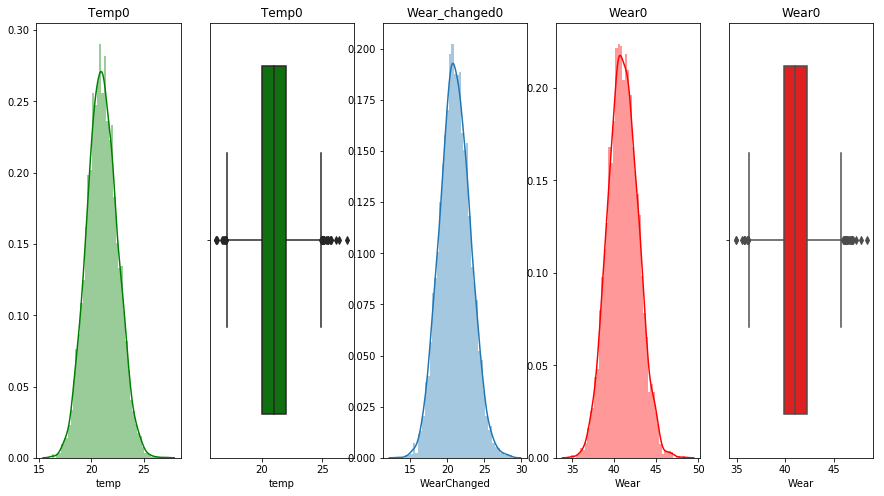

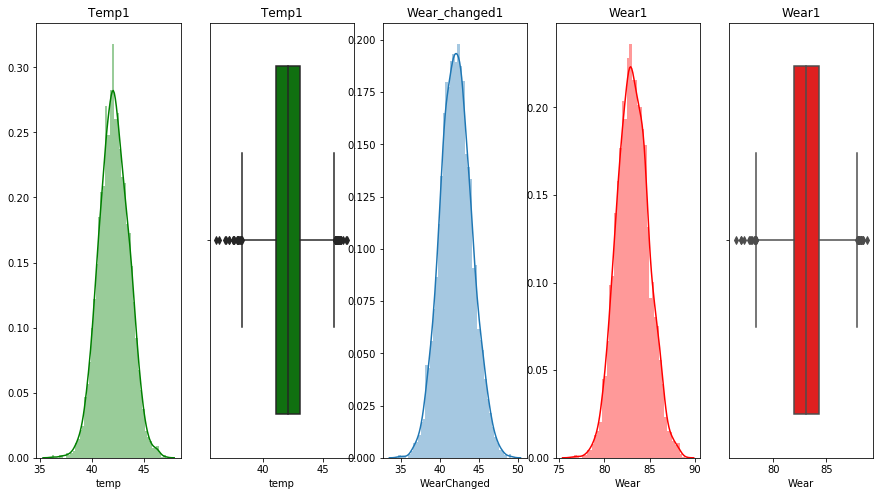

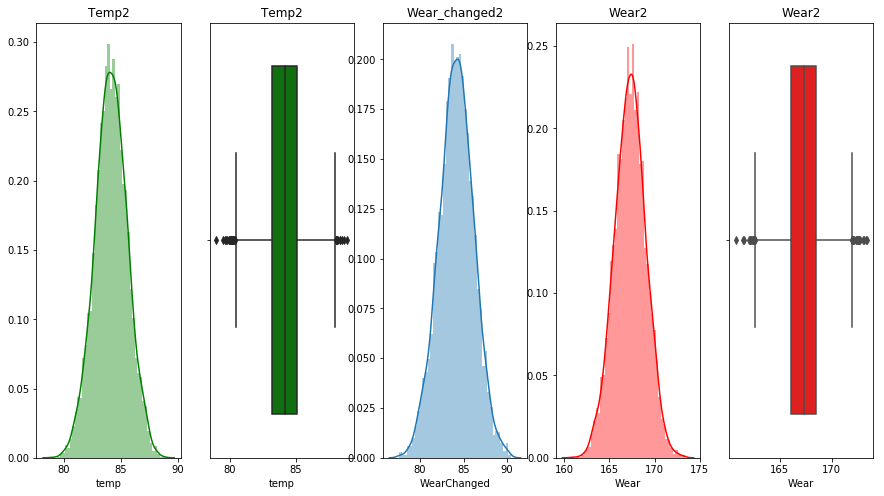

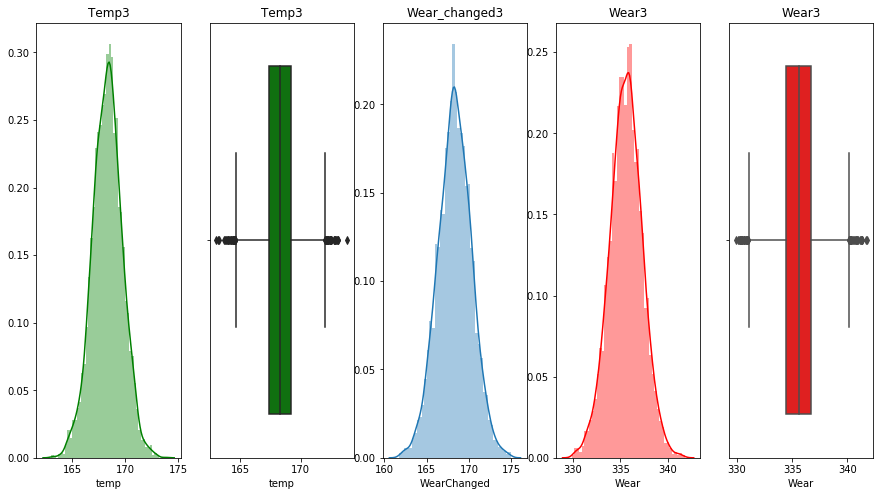

In [30]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,5)
    fig.set_figheight(8)
    fig.set_figwidth(15)    
    #plt.figure(i)
    #plt.grid(True)
    seaborn.distplot(globals()["predStep" + str(i)].temp,ax=ax[0],color='green').set_title("Temp"+str(i))
    seaborn.boxplot(globals()["predStep" + str(i)].temp,ax=ax[1],color='green').set_title("Temp"+str(i))
    seaborn.distplot(globals()["predStep" + str(i)].WearChanged,ax=ax[2]).set_title("Wear_changed"+str(i))
    seaborn.distplot(globals()["predStep" + str(i)].Wear,ax=ax[3],color='r').set_title("Wear"+str(i))
    seaborn.boxplot(globals()["predStep" + str(i)].Wear,ax=ax[4],color='r').set_title("Wear"+str(i))
    
    
    #seaborn.set_axis_labels("WearChanged","temp");
    #seaborn.distplot(globals()["predStep" + str(i)].Wear, ax=ax[1]).set_title("Wear"+str(i))    


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


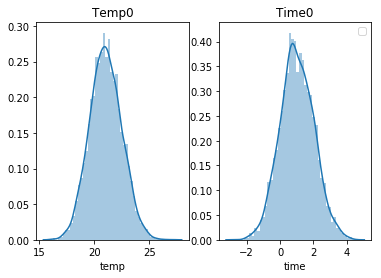

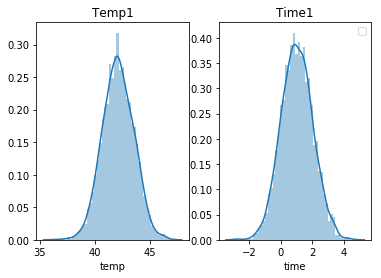

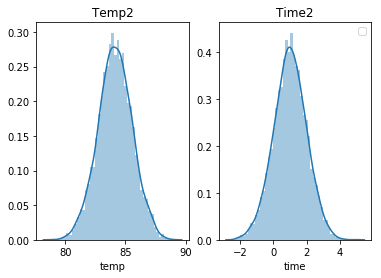

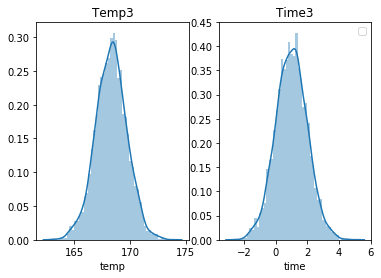

In [22]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,2)
    seaborn.distplot(globals()["predStep" + str(i)].temp,ax=ax[0]).set_title("Temp"+str(i))
    seaborn.distplot(globals()["predStep" + str(i)].time,ax=ax[1]).set_title("Time"+str(i))

    #seaborn.factorplot("Wear", data=globals()["predStep" + str(i)],ax=ax[1], kind="box")

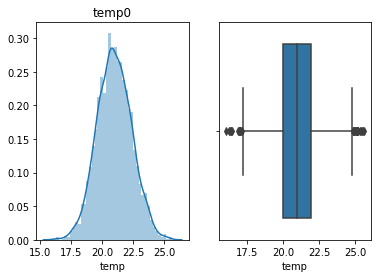

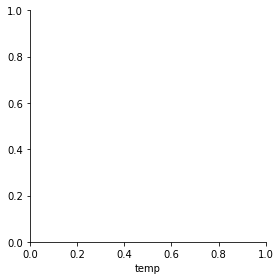

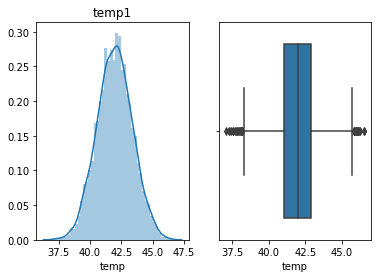

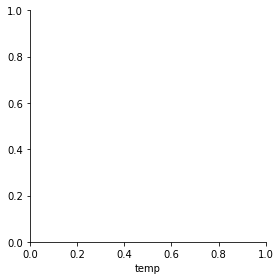

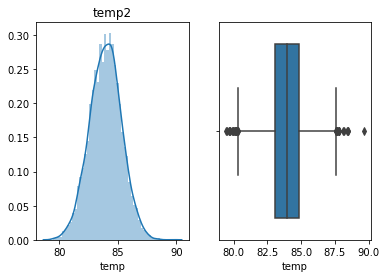

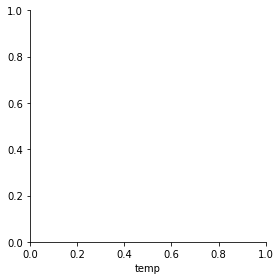

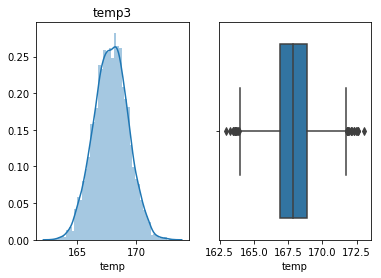

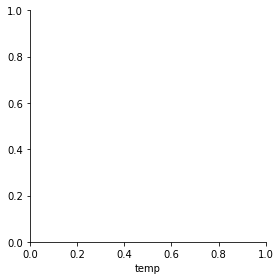

In [23]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,2)
    
    seaborn.distplot(globals()["predStep" + str(i)].temp,ax=ax[0]).set_title("temp"+str(i))    
    seaborn.factorplot("temp", data=globals()["predStep" + str(i)],ax=ax[1], kind="box") 
    

In [33]:
cdf = pd.read_csv("C:/Users/DESUSAI/Desktop/New folder/predStep_1.csv",sep=';')
cdf

,Unnamed: 0,Wear,WearChanged,temp,time
0,0,39.620614,20.190273,19.783483,0.549866
1,1,40.101901,20.787637,19.649792,0.084379
2,2,42.134106,22.600505,21.626043,0.804881
3,3,38.255197,18.369999,19.133692,1.169015
4,4,38.903985,20.653152,19.578485,-0.223101
5,5,41.779074,21.264797,19.826030,0.785236
6,6,42.662084,22.797111,21.534221,1.438706
7,7,42.790890,21.197351,21.950506,1.446429
8,8,41.215891,22.787287,21.833897,1.446441
9,9,42.626191,19.555743,23.526189,1.804766
